In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset

import numpy as np

import math

import time

import dataloader
import models
import training_fun

import optuna

import joblib

import HydroErr

from matplotlib import pyplot as plt

import HydroErr

c:\Users\User\Anaconda3\envs\pytorch1.13\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SEQ_LENGTH = 365 * 2
TARGET_SEQ_LENGTH = 365
BASE_LENGTH = SEQ_LENGTH - TARGET_SEQ_LENGTH

FORCING_DIM = 5

N_CATCHMENTS = 531

# training hyperparameters
EPOCHS = 500
TRAIN_YEAR = 10
PATIENCE = 20

use_amp = True
compile_model = False

if compile_model:
    torch.set_float32_matmul_precision("high")

memory_saving = False
if memory_saving:
    storge_device = "cpu"
    computing_device = DEVICE
    VAL_STEPS = 500
else:
    storge_device = DEVICE
    computing_device = DEVICE

In [4]:
study = joblib.load("data/531_daymet_original_lstm_study.pkl")

In [5]:
dtrain_val = dataloader.Forcing_Data(
    "data/531_daymet_original_camels_train_val.csv",
    record_length=3653,
    n_feature=FORCING_DIM,
    storge_device=storge_device,
    seq_length=SEQ_LENGTH,
    target_seq_length=TARGET_SEQ_LENGTH,
    base_length=BASE_LENGTH,
)

dtrain = dataloader.Forcing_Data(
    "data/531_daymet_original_camels_train.csv",
    record_length=2557,
    n_feature=FORCING_DIM,
    storge_device=storge_device,
    seq_length=SEQ_LENGTH,
    target_seq_length=TARGET_SEQ_LENGTH,
    base_length=BASE_LENGTH,
)

dval = dataloader.Forcing_Data(
    "data/531_daymet_original_camels_val.csv",
    record_length=1461,
    n_feature=FORCING_DIM,
    storge_device=storge_device,
    seq_length=SEQ_LENGTH,
    target_seq_length=TARGET_SEQ_LENGTH,
    base_length=BASE_LENGTH,
)

dtest = dataloader.Forcing_Data(
    "data/531_daymet_original_camels_test.csv",
    record_length=4017,
    n_feature=FORCING_DIM,
    storge_device=storge_device,
    seq_length=SEQ_LENGTH,
    target_seq_length=TARGET_SEQ_LENGTH,
    base_length=BASE_LENGTH,
)

In [6]:
def get_optimal_epochs(study):
    
    stats = study.best_trials[0].intermediate_values
    epochs = min(stats, key=lambda k: stats[k]) + 1
    
    return epochs

In [10]:
def get_final_model(study, dataset, n_catchments =N_CATCHMENTS, epoch_scale = 6/TRAIN_YEAR): #19/39

    trial = study.best_trial

    # define model
    model_builder = training_fun.LSTM_model_builder(
        n_catchments, base_length=365, forcing_dim=FORCING_DIM
    )

    embedding, decoder = model_builder.define_model(trial)

    embedding, decoder = embedding.to(computing_device), decoder.to(
        computing_device
    )

    if compile_model:
        # pytorch2.0 new feature, complile model for fast training
        embedding, decoder = torch.compile(embedding), torch.compile(decoder)


    # define model training hyperparameters
    # define optimizers
    lr_embedding = trial.suggest_float("lr_embedding", 5e-5, 1e-2, log=True)
    embedding_optimizer = optim.Adam(embedding.parameters(), lr=lr_embedding)

    lr_decoder = trial.suggest_float("lr_decoder", 5e-5, 1e-2, log=True)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=lr_decoder)

    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

    # define batch size
    batch_size_power = trial.suggest_int("batch_size_power", 4, 8)
    batch_size = 2**batch_size_power

    # define optimal epochs
    epochs = round(get_optimal_epochs(study)*epoch_scale)

        # steps per epoch
    steps = round(N_CATCHMENTS * TRAIN_YEAR / batch_size)

        # train model
    for epoch in range(epochs):

        # for each epoch get_random_batch method generates a batch that contains one year data for each catchment
        # repeat TRAIN_YEAR times to finish an epoch
        decoder.train()
        embedding.train()

        for step in range(steps):

            decoder_optimizer.zero_grad()
            embedding_optimizer.zero_grad()

            # put the models into training mode
            decoder.train()
            embedding.train()

            # get training batch and pass to device
            (x_batch, y_batch, selected_catchments) = dataset.get_random_batch(
                batch_size
            )

            x_batch, y_batch, selected_catchments = (
                x_batch.to(computing_device),
                y_batch.to(computing_device),
                selected_catchments.to(computing_device),
            )

            # slice batch for training
            with torch.autocast(
                device_type="cuda", dtype=torch.float16, enabled=use_amp
            ):
                code = embedding(selected_catchments)

                # pass through decoder
                out = decoder.decode(code, x_batch)

                # compute loss
                loss = training_fun.mse_loss_with_nans(out, y_batch)

            scaler.scale(loss).backward()
            scaler.step(embedding_optimizer)
            scaler.step(decoder_optimizer)
            scaler.update()

    return embedding, decoder

In [11]:
embedding, decoder = get_final_model(study, dtrain_val)

In [12]:
torch.save(embedding.cpu(), "data/531camles_final_lstm_embedding.pt")
torch.save(decoder.cpu(), "data/531camels_final_lstm_decoder.pt")

# Evaluation

In [13]:
embedding = torch.load("data/531camles_final_lstm_embedding.pt").to(computing_device)
decoder = torch.load("data/531camels_final_lstm_decoder.pt", map_location=torch.device('cpu')).to(computing_device)

embedding.eval()
decoder.eval()

# dimension of embedding
catchment_embeddings=[x.data for x in embedding.parameters()][0]
LATENT_dim = catchment_embeddings.shape[1]

In [14]:
class Objective_builder:
    def __init__(self, x, y, eval_fun):
        self.eval_fun = eval_fun
        self.x = x.contiguous()
        self.y = y.contiguous()
    
    def eval(self, code, return_summary = True):
        
        # numpy to torch tensor
        code = torch.from_numpy(code).unsqueeze(0).to(dtype=torch.float32).to(computing_device)
        code = code.expand(self.x.shape[0], -1)
        
        # BASE_LENGTH is from global
        pred = decoder.decode(code, self.x).view(-1).detach().cpu().numpy()

        ob = self.y.view(-1).detach().cpu().numpy()
        
        if return_summary:
          gof = self.eval_fun(simulated_array=pred, observed_array=ob)
          return gof
        else:
          return pred, ob

In [15]:
x_batch_test, y_batch_test = dtest.get_val_batch()
x_batch_test.shape, y_batch_test.shape

(torch.Size([11, 531, 730, 5]), torch.Size([11, 531, 365]))

In [16]:
def eval_catchment(selected_catchment):
    
    x = x_batch_test[:,selected_catchment,:,:]
    y = y_batch_test[:,selected_catchment,:]

    x, y = x.to(computing_device), y.to(computing_device)

    fn_kge = Objective_builder(x,y,HydroErr.kge_2009)
    fn_nse = Objective_builder(x,y,HydroErr.nse)
    
    kge = fn_kge.eval(catchment_embeddings[selected_catchment,:].cpu().detach().numpy())
    nse = fn_nse.eval(catchment_embeddings[selected_catchment,:].cpu().detach().numpy())
    
    return  kge, nse

In [17]:
calibrated_KGES = np.ones(N_CATCHMENTS)
calibrated_NSES = np.ones(N_CATCHMENTS)


for i in range(N_CATCHMENTS):
    #print(f'i={i} starts')
    calibrated_KGES[i], calibrated_NSES[i]  = eval_catchment(i)
    #print(f'fit={calibrated_KGES[i]}')

c:\Users\User\Anaconda3\envs\pytorch1.13\lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [3652 3653 3654 3655 3656 3657 3658 3659 3660 3661 3662 3663 3664 3665
 3666 3667 3668 3669 3670 3671 3672 3673 3674 3675 3676 3677 3678 3679
 3680 3681 3682 3683 3684 3685 3686 3687 3688 3689 3690 3691 3692 3693
 3694 3695 3696 3697 3698 3699 3700 3701 3702 3703 3704 3705 3706 3707
 3708 3709 3710 3711 3712 3713 3714 3715 3716 3717 3718 3719 3720 3721
 3722 3723 3724 3725 3726 3727 3728 3729 3730 3731 3732 3733 3734 3735
 3736 3737 3738 3739 3740 3741 3742 3743 3744 3745 3746 3747 3748 3749
 3750 3751 3752 3753 3754 3755 3756 3757 3758 3759 3760 3761 3762 3763
 3764 3765 3766 3767 3768 3769 3770 3771 3772 3773 3774 3775 3776 3777
 3778 3779 3780 3781 3782 3783 3784 3785 3786 3787 3788 3789 3790 3791
 3792 3793 3794 3795 3796 3797 3798 3799 3800 3801 3802 3803 3804 3805
 3806 3807 3808 3809 3810 3811 3812 3813 3814 3815 3816 3817 3818 3819
 3820 3821 3822 3823 3824 3825 3826 3827 3

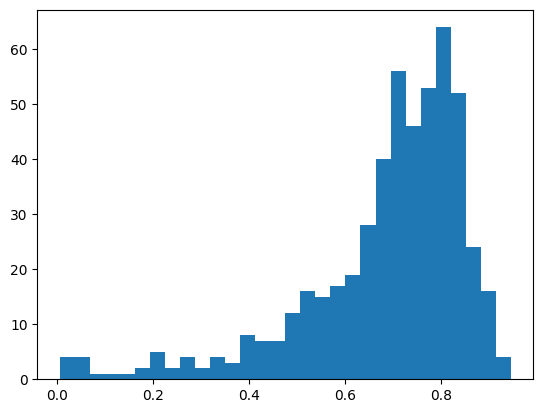

In [18]:
from matplotlib import pyplot as plt

plt.hist(calibrated_NSES[calibrated_NSES>0], bins = 30)
plt.show()

In [19]:
np.median(calibrated_KGES),calibrated_KGES.mean()

(0.711998773627114, 0.6427202524752138)

In [20]:
np.median(calibrated_NSES),calibrated_NSES.mean()

(0.7238228917121887, 0.6601925447667386)